4422102/4422102 [==============================] - 0s 0us/step
Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 28, 28, 1)]          0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 14, 14, 32)           320       ['input_1[0][0]']             
                                                                                                  
 conv2d_1 (Conv2D)           (None, 7, 7, 64)             18496     ['conv2d[0][0]']              
                                                                                                  
 flatten (Flatten)           (None, 3136)                 0         ['conv2d_1[0][0]']            
                             

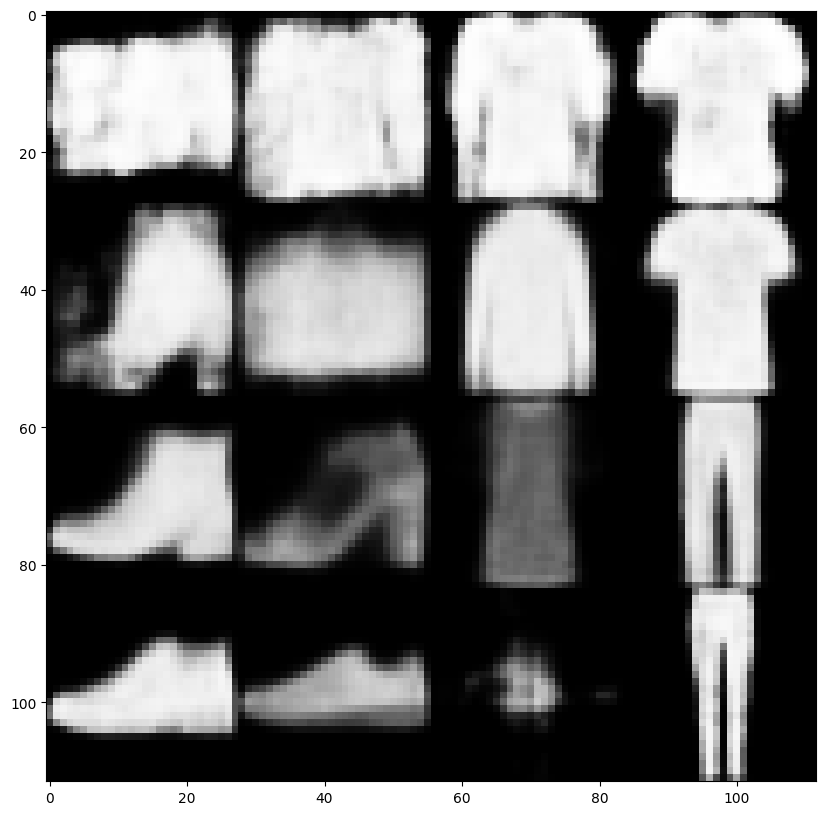

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras import layers, models, losses, optimizers, metrics, datasets, callbacks
import tensorflow.keras.backend as K

# 파라미터 설정
IMAGE_SIZE = 28
LATENT_DIM = 2
BATCH_SIZE = 128
EPOCHS = 20

# 데이터 로드 및 전처리
(x_train, _), (x_test, _) = datasets.fashion_mnist.load_data()
x_train = x_train.astype("float32") / 255.0
x_test = x_test.astype("float32") / 255.0
x_train = np.expand_dims(x_train, -1)
x_test = np.expand_dims(x_test, -1)

# 인코더 정의
encoder_inputs = layers.Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 1))
x = layers.Conv2D(32, 3, activation='relu', strides=2, padding='same')(encoder_inputs)
x = layers.Conv2D(64, 3, activation='relu', strides=2, padding='same')(x)
x = layers.Flatten()(x)
x = layers.Dense(16, activation='relu')(x)
z_mean = layers.Dense(LATENT_DIM, name='z_mean')(x)
z_log_var = layers.Dense(LATENT_DIM, name='z_log_var')(x)

def sampling(args):
    z_mean, z_log_var = args
    batch = tf.shape(z_mean)[0]
    dim = tf.shape(z_mean)[1]
    epsilon = K.random_normal(shape=(batch, dim))
    return z_mean + K.exp(0.5 * z_log_var) * epsilon

z = layers.Lambda(sampling)([z_mean, z_log_var])

encoder = models.Model(encoder_inputs, [z_mean, z_log_var, z], name='encoder')
encoder.summary()

# 디코더 정의
latent_inputs = layers.Input(shape=(LATENT_DIM,))
x = layers.Dense(7 * 7 * 64, activation='relu')(latent_inputs)
x = layers.Reshape((7, 7, 64))(x)
x = layers.Conv2DTranspose(64, 3, activation='relu', strides=2, padding='same')(x)
x = layers.Conv2DTranspose(32, 3, activation='relu', strides=2, padding='same')(x)
decoder_outputs = layers.Conv2DTranspose(1, 3, activation='sigmoid', padding='same')(x)

decoder = models.Model(latent_inputs, decoder_outputs, name='decoder')
decoder.summary()

# VAE 모델 정의
class VAE(models.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = metrics.Mean(name="reconstruction_loss")
        self.kl_loss_tracker = metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        return [self.total_loss_tracker, self.reconstruction_loss_tracker, self.kl_loss_tracker]

    def call(self, inputs):
        z_mean, z_log_var, z = self.encoder(inputs)
        reconstructed = self.decoder(z)
        return reconstructed

    def train_step(self, data):
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data)
            reconstruction = self.decoder(z)
            reconstruction_loss = tf.reduce_mean(
                tf.reduce_sum(losses.binary_crossentropy(data, reconstruction), axis=(1, 2))
            )
            kl_loss = -0.5 * tf.reduce_mean(
                tf.reduce_sum(1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var), axis=1)
            )
            total_loss = reconstruction_loss + kl_loss
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }

vae = VAE(encoder, decoder)
vae.compile(optimizer=optimizers.Adam())

# 모델 훈련
vae.fit(x_train, epochs=EPOCHS, batch_size=BATCH_SIZE, validation_data=(x_test, None))

# 잠재 공간에서 이미지 생성
n = 4
figure = np.zeros((IMAGE_SIZE * n, IMAGE_SIZE * n))
grid_x = np.linspace(-2, 2, n)
grid_y = np.linspace(-2, 2, n)

for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        z_sample = np.array([[xi, yi]])
        x_decoded = decoder.predict(z_sample)
        digit = x_decoded[0].reshape(IMAGE_SIZE, IMAGE_SIZE)
        figure[i * IMAGE_SIZE: (i + 1) * IMAGE_SIZE,
               j * IMAGE_SIZE: (j + 1) * IMAGE_SIZE] = digit

plt.figure(figsize=(10, 10))
plt.imshow(figure, cmap='Greys_r')
plt.show()


1/1 [==============================] - 0s 29ms/step


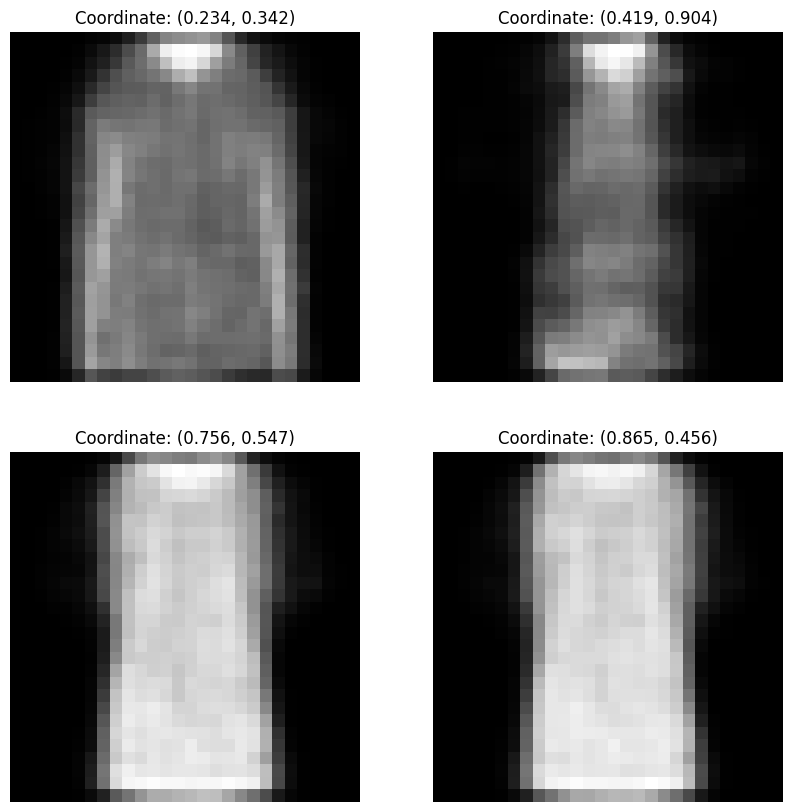

In [2]:
# 지정된 좌표에서 이미지 생성
coordinates = [(0.234, 0.342), (0.419, 0.904), (0.756, 0.547), (0.865, 0.456)]
generated_images = []

for coord in coordinates:
    z_sample = np.array([coord])
    x_decoded = decoder.predict(z_sample)
    digit = x_decoded[0].reshape(IMAGE_SIZE, IMAGE_SIZE)
    generated_images.append(digit)

# 생성된 이미지 시각화
plt.figure(figsize=(10, 10))
for i, image in enumerate(generated_images):
    plt.subplot(2, 2, i + 1)
    plt.imshow(image, cmap='Greys_r')
    plt.title(f"Coordinate: {coordinates[i]}")
    plt.axis('off')
plt.show()

1/1 [==============================] - 0s 23ms/step


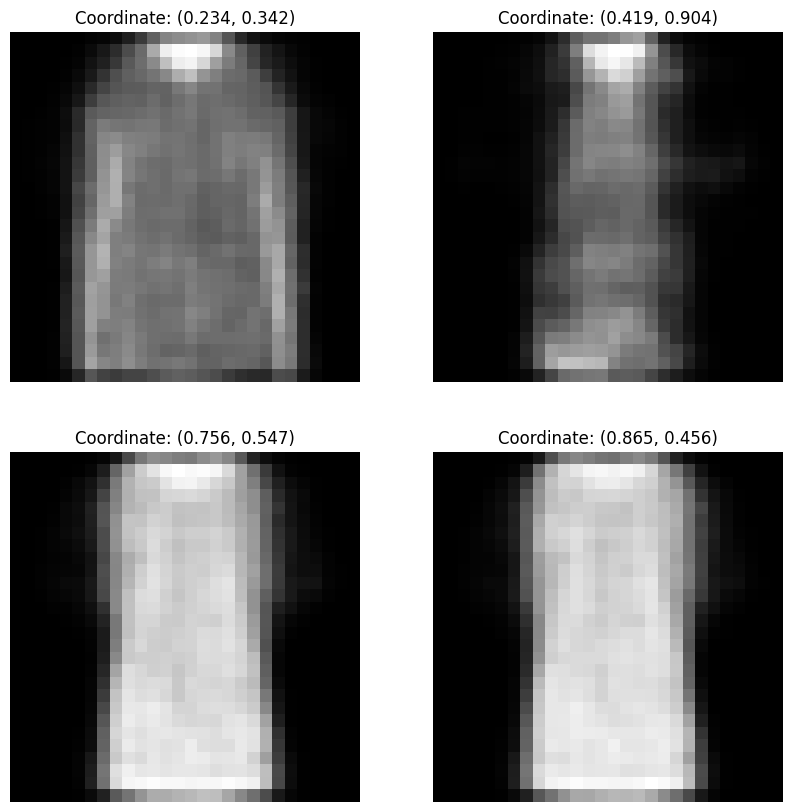

In [3]:
coordinates = [(0.234, 0.342), (0.419, 0.904), (0.756, 0.547), (0.865, 0.456)]
generated_images = []

for coord in coordinates:
    z_sample = np.array([coord])
    x_decoded = decoder.predict(z_sample)
    digit = x_decoded[0].reshape(IMAGE_SIZE, IMAGE_SIZE)
    generated_images.append(digit)

# 생성된 이미지 시각화
fig, axs = plt.subplots(2, 2, figsize=(10, 10))
for i, image in enumerate(generated_images):
    row, col = divmod(i, 2)
    axs[row, col].imshow(image, cmap='Greys_r')
    axs[row, col].set_title(f"Coordinate: {coordinates[i]}")
    axs[row, col].axis('off')

plt.show()